<a href="https://colab.research.google.com/github/larasauser/master/blob/main/nspi_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NSPI - 3
(based on Chen et al. 2011)

In [1]:
!pip install rasterio
!pip install numpy
!pip install opencv-python
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 42.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import rasterio
from rasterio.plot import show
import cv2
import tqdm
from math import sqrt
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import rasterio
from matplotlib import cm
from datetime import datetime

In [14]:
import os
import numpy as np
import rasterio
from datetime import datetime
from rasterio.warp import reproject, Resampling

def choose_reference(target_path, candidate_folder, gap_mask, alpha=0.7, beta=0.3, month_window=1):
    """
    Chooses the best reference image for NSPI with temporal filtering and automatic recropping.
    Returns:
        ref_img: reference image recadrée pour matcher target
        ref_name: nom du fichier référence
        best_score: score de similarité
    """
    target_name = os.path.basename(target_path)
    target_date = datetime.strptime(target_name.split('_')[-1].split('.tif')[0], "%Y-%m-%d")

    with rasterio.open(target_path) as src:
        target_img = src.read(1).astype(np.float32)
        target_transform = src.transform
        target_crs = src.crs

    best_score = -np.inf
    best_ref_path = None

    for fname in os.listdir(candidate_folder):
        if not fname.endswith(".tif"):
            continue
        if fname == target_name:
            continue

        cand_date = datetime.strptime(fname.split('_')[-1].split('.tif')[0], "%Y-%m-%d")

        # Compute month difference allowing ±month_window (cross-year)
        month_diff = cand_date.month - target_date.month
        if month_diff < -12 + month_window or month_diff > 12 - month_window:
            month_diff += 12 if month_diff < 0 else -12
        if abs(month_diff) > month_window:
            continue

        candidate_path = os.path.join(candidate_folder, fname)

        with rasterio.open(candidate_path) as src:
            cand_img = src.read(1).astype(np.float32)
            cand_transform = src.transform
            cand_crs = src.crs

        # Reproject / recadrage pour matcher target
        recropped = np.empty_like(target_img)
        reproject(
            source=cand_img,
            destination=recropped,
            src_transform=cand_transform,
            src_crs=cand_crs,
            dst_transform=target_transform,
            dst_crs=target_crs,
            resampling=Resampling.bilinear
        )

        valid_mask = ~gap_mask & ~np.isnan(recropped)
        if np.sum(valid_mask) == 0:
            continue

        diff = recropped[valid_mask] - recropped[valid_mask].mean()
        score = alpha * np.corrcoef(diff.flatten(), diff.flatten())[0,1] - beta * np.std(diff)

        if score > best_score:
            best_score = score
            best_ref_path = candidate_path
            best_ref_name = fname
            best_ref_img = recropped

    if best_ref_path is None:
        raise ValueError("No suitable reference found within the temporal window.")

    return best_ref_img, best_ref_name, best_score


In [15]:
def compute_rmsd(p1, p2):
    return np.sqrt(np.nanmean(p1-p2)**2)

In [16]:
def select_similar_pixels(ref_patch, target_patch, gap_patch, stds, m, max_window):
    h, w = ref_patch.shape
    x_c, y_c = h // 2, w // 2
    target_pixel = ref_patch[x_c, y_c]

    if np.isnan(target_pixel):
        return [], []

    similar_pixels, distances = [], []

    for i in range(h):
        for j in range(w):
            if gap_patch[i, j]:
                continue
            candidate = ref_patch[i, j]
            if np.isnan(candidate):
                continue
            rmsd = np.sqrt((candidate - target_pixel) ** 2)
            threshold = 2 * stds / m
            if rmsd <= threshold:
                similar_pixels.append(((i, j), candidate))
                distances.append(np.linalg.norm([i - x_c, j - y_c]))
    return similar_pixels, distances


In [17]:
def predict_pixel_value(similar_pixels, distances, ref_patch, target_patch, stds, m, max_window, ref_center, target_center):
    if len(similar_pixels) == 0:
        return None

    rmsds = [compute_rmsd(ref_patch[i, j], ref_center) for (i, j), _ in similar_pixels]
    cds = [r * d for r, d in zip(rmsds, distances)]
    weights = 1 / (np.array(cds) + 1e-6)
    weights /= weights.sum()

    L1 = 0.0
    for w, ((i, j), _) in zip(weights, similar_pixels):
        L1 += w * target_patch[i, j]

    delta = 0.0
    for w, ((i, j), _) in zip(weights, similar_pixels):
        delta += w * (target_patch[i, j] - ref_patch[i, j])
    L2 = ref_center + delta

    R1 = np.mean([compute_rmsd(ref_patch[i, j], ref_center) for (i, j), _ in similar_pixels])
    R2 = np.mean([compute_rmsd(target_patch[i, j], ref_patch[i, j]) for (i, j), _ in similar_pixels])

    T1 = 1 / R1 if R1 != 0 else 1e6
    T2 = 1 / R2 if R2 != 0 else 1e6
    T_sum = T1 + T2
    T1, T2 = T1 / T_sum, T2 / T_sum

    return T1 * L1 + T2 * L2


In [13]:
#OLD
def filled_gaps_nspi(ground_truth, target_img, ref_img, gap_mask, m=20, max_window=51):
    filled = target_img.copy()
    h, w = target_img.shape
    pad = max_window // 2
    padded_target = np.pad(target_img, ((pad, pad), (pad, pad)), mode='reflect')
    padded_ref = np.pad(ref_img, ((pad, pad), (pad, pad)), mode='reflect')
    padded_mask = np.pad(gap_mask, ((pad, pad), (pad, pad)), mode='constant', constant_values=1)

    stds = np.nanstd(ref_img[~gap_mask])

    for y in tqdm(range(pad, pad + h)):
        for x in range(pad, pad + w):
            if not gap_mask[y - pad, x - pad]:
                continue

            for window in range(6, max_window + 1, 2):
                r = window // 2
                ref_patch = padded_ref[y - r:y + r + 1, x - r:x + r + 1]
                target_patch = padded_target[y - r:y + r + 1, x - r:x + 1 + r]
                mask_patch = padded_mask[y - r:y + r + 1, x - r:x + 1 + r]

                similar_pixels, distances = select_similar_pixels(ref_patch, target_patch, mask_patch, stds, m, max_window)

                if len(similar_pixels) >= m or window == max_window:
                    val = predict_pixel_value(similar_pixels, distances, ref_patch, target_patch, stds, m, max_window,
                                              ref_patch[r, r], target_patch[r, r])
                    if val is not None:
                        filled[y - pad, x - pad] = val
                    break
    return filled


In [29]:
def filled_gaps_nspi(ground_truth, target_img, ref_img, gap_mask, m=20, max_window=17):
    filled = target_img.copy()
    h, w = target_img.shape
    pad = max_window // 2
    padded_target = np.pad(target_img, ((pad, pad), (pad, pad)), mode='reflect')
    padded_ref = np.pad(ref_img, ((pad, pad), (pad, pad)), mode='reflect')
    padded_mask = np.pad(gap_mask, ((pad, pad), (pad, pad)), mode='constant', constant_values=1)

    stds = np.nanstd(ref_img[~gap_mask])

    for y in tqdm(range(pad, pad + h)):
        for x in range(pad, pad + w):
            if not gap_mask[y - pad, x - pad]:
                continue

            for window in range(6, max_window + 1, 2):
                r = window // 2
                ref_patch = padded_ref[y - r:y + r + 1, x - r:x + r + 1]
                target_patch = padded_target[y - r:y + r + 1, x - r:x + r + 1]
                mask_patch = padded_mask[y - r:y + r + 1, x - r:x + r + 1]

                similar_pixels, distances = select_similar_pixels(
                    ref_patch, target_patch, mask_patch, stds, m, max_window
                )

                # Cas spécial : aucun pixel similaire trouvé à la fenêtre max
                if len(similar_pixels) == 0 and window == max_window:
                    # utiliser tous les pixels valides du patch
                    similar_pixels = [((i, j), ref_patch[i, j])
                                      for i in range(ref_patch.shape[0])
                                      for j in range(ref_patch.shape[1])
                                      if not mask_patch[i, j] and not np.isnan(ref_patch[i, j])]
                    distances = [np.linalg.norm([i - r, j - r]) for (i, j), _ in similar_pixels]

                # Si assez de pixels ou fenêtre max atteinte, on prédit
                if len(similar_pixels) >= m or window == max_window:
                    val = predict_pixel_value(
                        similar_pixels, distances, ref_patch, target_patch, stds, m, max_window,
                        ref_patch[r, r], target_patch[r, r]
                    )
                    if val is not None:
                        filled[y - pad, x - pad] = val
                    break
    return filled


In [20]:
def load_image(path):
    with rasterio.open(path) as src:
        img = src.read(1).astype(np.float32)
        profile = src.profile
    return img, profile

In [21]:
def visu_5(gt_img, target_img, filled_img, ref_img, gap_mask, gt_path, target_path, ref_path, band=0):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import numpy as np
    import rasterio
    import os

    # Ensure all images have 3 dimensions
    if gt_img.ndim == 2:
        gt_img = gt_img[:, :, np.newaxis]
    if target_img.ndim == 2:
        target_img = target_img[:, :, np.newaxis]
    if filled_img.ndim == 2:
        filled_img = filled_img[:, :, np.newaxis]
    if ref_img.ndim == 2:
        ref_img = ref_img[:, :, np.newaxis]

    # Extract names
    gt_name = os.path.splitext(os.path.basename(gt_path))[0]
    target_name = os.path.splitext(os.path.basename(target_path))[0]
    ref_name = os.path.splitext(os.path.basename(ref_path))[0]

    # Replace -9999 by NaN
    gt_band = np.where(gt_img[:, :, band] == -9999, np.nan, gt_img[:, :, band])
    target_band = np.where(target_img[:, :, band] == -9999, np.nan, target_img[:, :, band])
    filled_band = np.where(filled_img[:, :, band] == -9999, np.nan, filled_img[:, :, band])
    ref_band = np.where(ref_img[:, :, band] == -9999, np.nan, ref_img[:, :, band])

    # Error only on gaps
    error_band = np.full_like(gt_band, np.nan)
    error_band[gap_mask] = gt_band[gap_mask] - filled_band[gap_mask]

    # Get extent from ground truth
    with rasterio.open(gt_path) as src:
        bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

    # NDVI colormap: grayscale, gaps in red
    ndvi_cmap = cm.get_cmap("gray").copy()
    ndvi_cmap.set_bad(color="red")

    fig, axes = plt.subplots(2, 3, figsize=(24, 12), constrained_layout=True)
    axes = axes.flatten()

    # Panels
    im0 = axes[0].imshow(gt_band, cmap=ndvi_cmap, vmin=-1, vmax=1, extent=extent)
    axes[0].set_title(f"Ground truth - {gt_name}", fontsize=14)
    im1 = axes[1].imshow(target_band, cmap=ndvi_cmap, vmin=-1, vmax=1, extent=extent)
    axes[1].set_title(f"Target - {target_name}", fontsize=14)
    im2 = axes[2].imshow(filled_band, cmap=ndvi_cmap, vmin=-1, vmax=1, extent=extent)
    axes[2].set_title("Filled", fontsize=14)
    im3 = axes[3].imshow(ref_band, cmap=ndvi_cmap, vmin=-1, vmax=1, extent=extent)
    axes[3].set_title(f"Reference - {ref_name}", fontsize=14)
    im4 = axes[4].imshow(error_band, cmap=cm.RdYlGn, extent=extent)
    axes[4].set_title("Error (GT - Filled) on gaps", fontsize=14)

    # Remove 6th empty subplot
    fig.delaxes(axes[5])

    # Colorbars
    cbar = fig.colorbar(im2, ax=axes[:4], orientation='vertical', fraction=0.03, pad=0.01)
    cbar.set_label("NDVI", fontsize=12)
    cbar2 = fig.colorbar(im4, ax=axes[4], orientation='vertical', fraction=0.03, pad=0.01)
    cbar2.set_label("NDVI Error", fontsize=12)

    plt.show()


computation

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Paths
ground_truth_path = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/NDVI_2018-05-25.tif"
target_path = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/holes_real/NDVI_2018-05-25.tif"
candidate_folder = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed"

# Load images
ground_truth, profile = load_image(ground_truth_path)
target_img, _ = load_image(target_path)

# Define gap mask (True where pixels are invalid)
gap_mask = (target_img == -9999) | np.isnan(target_img)

# Replace -9999 with NaN for processing
#target_img = np.where(gap_mask, np.nan, target_img)

# Choose reference image
ref_img, ref_date, score = choose_reference(target_path, candidate_folder, gap_mask)
print("Best reference date:", ref_date, " Score:", score)


Best reference date: NDVI_2021-06-18.tif  Score: 0.6780715703964233


In [51]:
# Fill gaps
filled_img = filled_gaps_nspi(ground_truth, target_img, ref_img, gap_mask, max_window=25)

# Save result
out_path = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/holes_real/filled_nspi3/NDVI_2013-04-18.tif"
with rasterio.open(out_path, "w", **profile) as dst:
    dst.write(filled_img, 1)

print("Saved filled image:", out_path)

100%|██████████| 347/347 [01:54<00:00,  3.02it/s]


Saved filled image: /content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/holes_real/filled_nspi3/NDVI_2013-04-18.tif


/tmp/ipython-input-1560671711.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ndvi_cmap = cm.get_cmap("gray").copy()


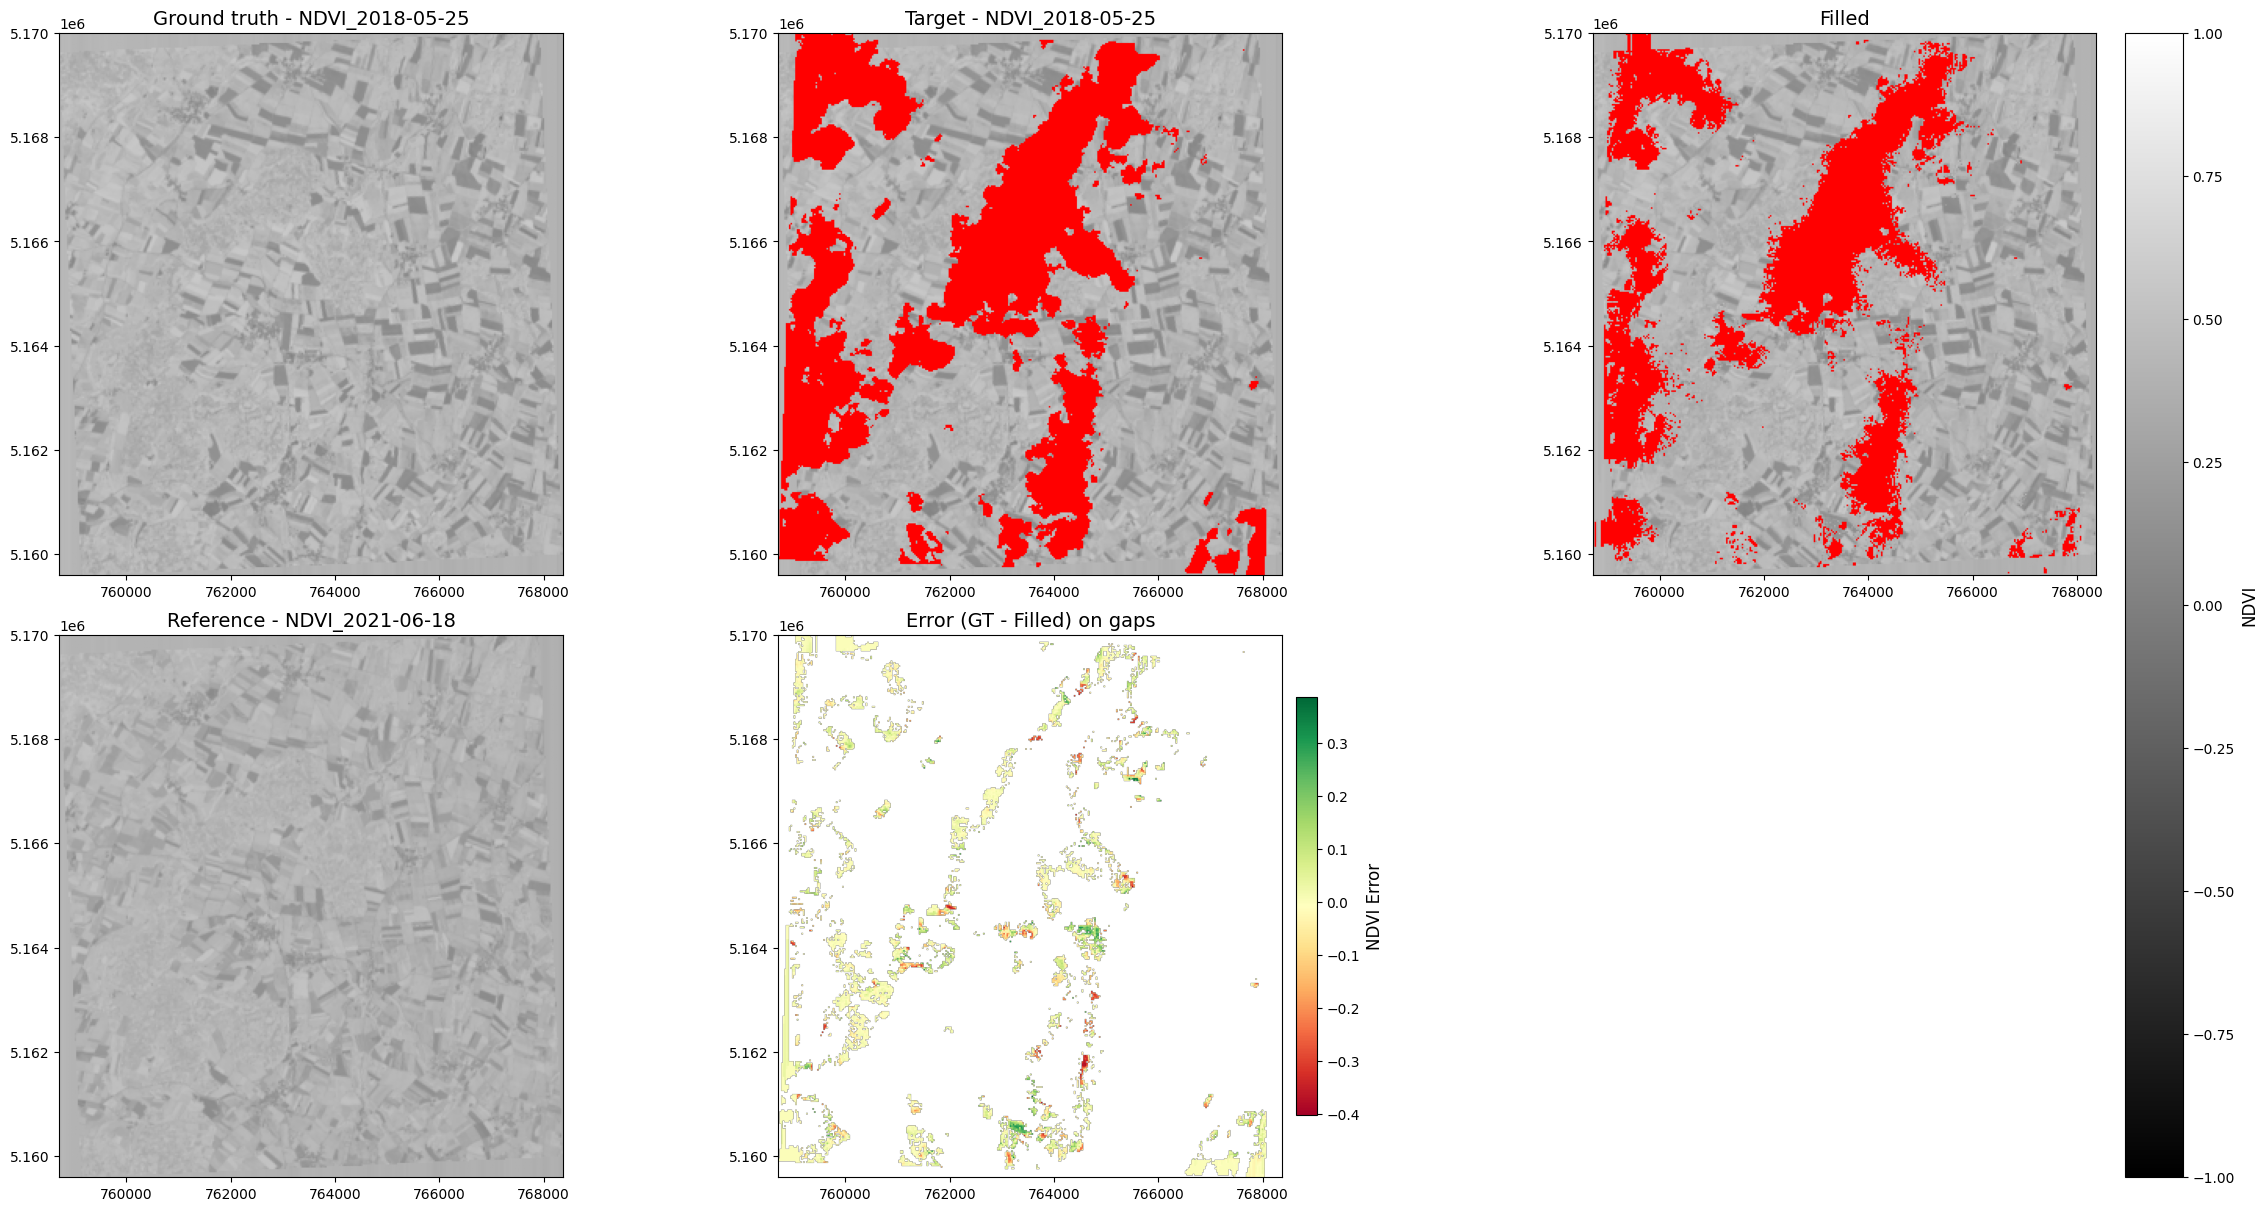

In [52]:
#Visualisation
ref_path = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/NDVI_2021-06-18.tif"
visu_5(ground_truth, target_img, filled_img, ref_img, gap_mask, ground_truth_path, target_path, ref_path)

Metrics

In [36]:
!pip install piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 2.5 MB/s eta 0:00:00


In [43]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import piq
import torch

def evaluate_nspi_metrics(ground_truth, filled_img, gap_mask, image_name):
    """
    Evaluates gap-filling quality using standard metrics.
    Uses the zero-fill method for MS-SSIM calculation.
    """
    ground_truth = np.squeeze(np.array(ground_truth))
    filled_img = np.squeeze(np.array(filled_img))
    gap_mask = np.squeeze(np.array(gap_mask)).astype(bool)

    if ground_truth.shape != filled_img.shape or ground_truth.shape != gap_mask.shape:
        raise ValueError(f"Incompatible shapes: {ground_truth.shape}, {filled_img.shape}, {gap_mask.shape}")

    valid_mask = gap_mask & ~np.isnan(ground_truth) & ~np.isnan(filled_img)
    if np.sum(valid_mask) == 0:
        return pd.DataFrame([{
            'Image name': image_name,
            'RMSE': np.nan, 'R²': np.nan, 'MAE': np.nan,
            'MS-SSIM': np.nan, '% reconstructed pixels': 0.0
        }])

    # --- Error-based Metrics (RMSE, R², MAE) ---
    y_true = ground_truth[valid_mask]
    y_pred = filled_img[valid_mask]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    if np.var(y_true) < 1e-8:
        r2 = np.nan
    else:
        r2 = r2_score(y_true, y_pred)

    mae = np.mean(np.abs(y_true - y_pred))

    # --- MS-SSIM ---
    min_val = np.nanmin([ground_truth[valid_mask], filled_img[valid_mask]])
    max_val = np.nanmax([ground_truth[valid_mask], filled_img[valid_mask]])

    if max_val - min_val < 1e-8:
        ms_ssim_score = np.nan
    else:
        gt_norm = (ground_truth - min_val) / (max_val - min_val)
        filled_norm = (filled_img - min_val) / (max_val - min_val)

        gt_norm[~valid_mask] = 0.0
        filled_norm[~valid_mask] = 0.0

        gt_tensor = torch.from_numpy(gt_norm).unsqueeze(0).unsqueeze(0).float()
        filled_tensor = torch.from_numpy(filled_norm).unsqueeze(0).unsqueeze(0).float()

        ms_ssim_score = piq.multi_scale_ssim(
            gt_tensor, filled_tensor, data_range=1., reduction='none'
        ).item()

    coverage = (np.sum(valid_mask) / np.sum(gap_mask)) * 100 if np.sum(gap_mask) > 0 else 0.0

    results = {
        'Image name': image_name,
        'RMSE': rmse,
        'R²': r2,
        'MAE': mae,
        'MS-SSIM': ms_ssim_score,
        '% reconstructed pixels': coverage
    }
    return pd.DataFrame([results])


In [53]:
df = evaluate_nspi_metrics(ground_truth, filled_img, gap_mask, "NDVI_2013-04-18")
df

,Image name,RMSE,R²,MAE,MS-SSIM,% reconstructed pixels
0,NDVI_2013-04-18,0.082265,0.072759,0.0505,0.977416,30.276502
